# Use Case: Process Video Datasets from Spacetime Perspectives

This notebook demonstrates how to use some Data-Juicer OPs to process video datasets from spacetime perspectives.

Compared with image-text datasets, videos can be regarded as a series of images, where time dimension is added in addition to space dimension. Therefore, many space-related OPs can be transfered and applied on videos easily, and some new dedicated time-related OPs are required by video datasets. In this notebook, we will learn how to process videos from these two perspectives with Data-Juicer.

Specifically, we will take `video_ocr_area_ratio_filter` and `video_motion_score_filter` as example OPs. The former one, `video_ocr_area_ratio_filter`, is actually a transfered image-based capability, which samples several frames from videos and check the textual area ratio to the whole frame area. The latter one, `video_motion_score_filter`, analyze the dense optical flow and compute a motion score for the video to indicate how dynamic the video is. More details about these two OPs can be found in the [config_all.yaml](https://github.com/modelscope/data-juicer/blob/feat/tutorials/configs/config_all.yaml) file and their corresponding code implementations.

Now, let's begin the this notebook by preparing an example video dataset.

## Dataset Preparation

Here we only consider a example dataset of two video samples. We write it to a `jsonl` file first. Due to the Data-Juicer format is a text-based format, so we need to add the video special token in the text field as well to indicate there is videos in this sample.

The intermediate format of multimodal datasets in Data-Juicer is defined [here](https://github.com/modelscope/data-juicer/blob/main/tools/multimodal/README.md).

In [2]:
import jsonlines as jl

ds = [
    {
        'text': '<__dj__video>',
        'videos': ['vids/video1.mp4'],
    },
    {
        'text': '<__dj__video>',
        'videos': ['vids/video2.mp4'],
    }
]

with jl.open('ds.jsonl', 'w') as writer:
    writer.write_all(ds)

And we download these two example videos to `./vids`.

In [2]:
!mkdir -p vids && wget http://dail-wlcb.oss-cn-wulanchabu.aliyuncs.com/data_juicer/tutorial_data/video1.mp4 -O ./vids/video1.mp4 && wget http://dail-wlcb.oss-cn-wulanchabu.aliyuncs.com/data_juicer/tutorial_data/video2.mp4 -O ./vids/video2.mp4

--2024-08-12 16:13:56--  http://dail-wlcb.oss-cn-wulanchabu.aliyuncs.com/data_juicer/tutorial_data/video1.mp4
Resolving dail-wlcb.oss-cn-wulanchabu.aliyuncs.com (dail-wlcb.oss-cn-wulanchabu.aliyuncs.com)... 39.101.35.6
Connecting to dail-wlcb.oss-cn-wulanchabu.aliyuncs.com (dail-wlcb.oss-cn-wulanchabu.aliyuncs.com)|39.101.35.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789238 (771K) [video/mp4]
Saving to: ‘./vids/video1.mp4’

./vids/video1.mp4   100%[===================>] 770.74K  3.24MB/s    in 0.2s    

2024-08-12 16:13:57 (3.24 MB/s) - ‘./vids/video1.mp4’ saved [789238/789238]

--2024-08-12 16:13:57--  http://dail-wlcb.oss-cn-wulanchabu.aliyuncs.com/data_juicer/tutorial_data/video2.mp4
Resolving dail-wlcb.oss-cn-wulanchabu.aliyuncs.com (dail-wlcb.oss-cn-wulanchabu.aliyuncs.com)... 39.101.35.6
Connecting to dail-wlcb.oss-cn-wulanchabu.aliyuncs.com (dail-wlcb.oss-cn-wulanchabu.aliyuncs.com)|39.101.35.6|:80... connected.
HTTP request sent, awaiting respons

### Visualization

We can also prepare a function to visualize the videos in the dataset and images.

In [3]:
from IPython.display import display, HTML

def vis(s):
    html_str = f'''
    <video controls src=\"{s['videos'][0]}\">video</video>
    '''
    display(HTML(html_str))

for s in ds:
    vis(s)


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
def show_imgs(img_path):
    img = Image.open(img_path)
    plt.imshow(np.asarray(img))
    plt.show()

## From Space Perspective

From the space perspective, we take `video_ocr_area_ratio_filter` as an example. This OP would detect text regions with OCR models in the sampled frames from the videos. If the total ratio of text area to the frame area is out of a specified range, this video would be filtered out. This OP is used for removing videos that contain too much texts because some previous works suggest too many texts might not be a good thing for the vision information.

Now we write a new recipe for this OP.

In [4]:
recipe = '''
dataset_path: ds.jsonl
export_path: outputs/video_space_output/res.jsonl

keep_stats_in_res_ds: true  # keep the computed stats in the result dataset

process:
  - video_ocr_area_ratio_filter:
      max_area_ratio: 0.2
      frame_sample_num: 3
'''

with open('video_space.yaml', 'w') as fout:
    fout.write(recipe)

Then we can run the process program of Data-Juicer to process the dataset.

In [7]:
!dj-process --config video_space.yaml

2024-08-12 17:19:56 | INFO     | data_juicer.config.config:618 - Back up the input config file [/root/projects/kdd_tutorial_notebooks/video_space.yaml] into the work_dir [/root/projects/kdd_tutorial_notebooks/outputs/video_space_output]
2024-08-12 17:19:56 | INFO     | data_juicer.config.config:640 - Configuration table: 
╒═════════════════════════╤══════════════════════════════════════════════════════════════════════════════╕
│ key                     │ values                                                                       │
╞═════════════════════════╪══════════════════════════════════════════════════════════════════════════════╡
│ config                  │ [Path_fr(video_space.yaml, cwd=/root/projects/kdd_tutorial_notebooks)]       │
├─────────────────────────┼──────────────────────────────────────────────────────────────────────────────┤
│ hpo_config              │ None                                                                         │
├─────────────────────────┼───────

We can check the processed results and check the stats.

In [6]:
with jl.open('outputs/video_space_output/res.jsonl') as reader:
    for s in reader:
        print(s)

{'text': '<__dj__video>', 'videos': ['/root/projects/kdd_tutorial_notebooks/vids/video1.mp4'], '__dj__stats__': {'video_ocr_area_ratio': [0.0672511574]}}


The OCR area ratio of this kept video is in the specified range [0, 0.2]. And if we want to check the detection results of each video, we need to uncomment the debug code of this OP and set the flag to True to write the detection result images to the video directory.
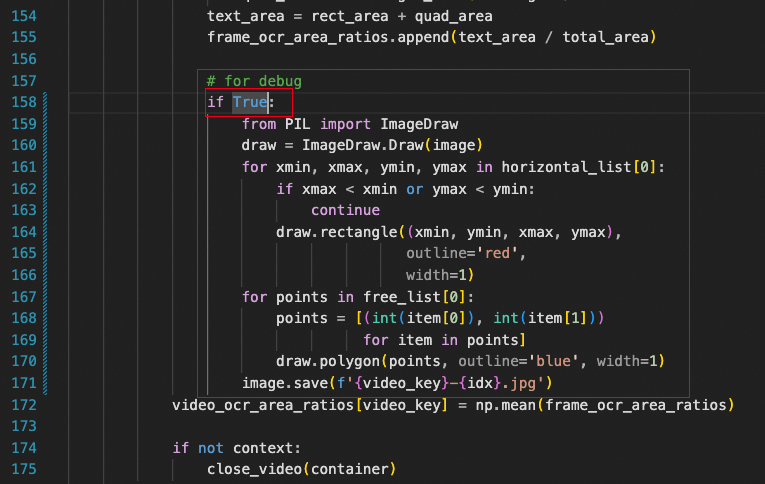

And then, we can visiualize the detection results of the sampled 3 frames of each videos.

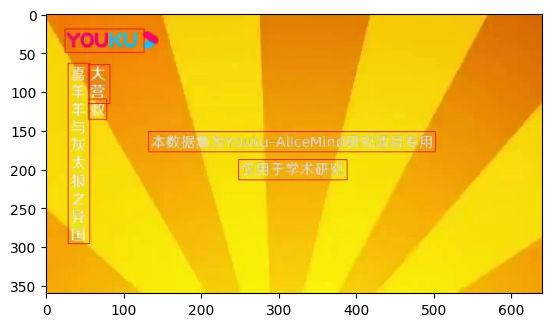

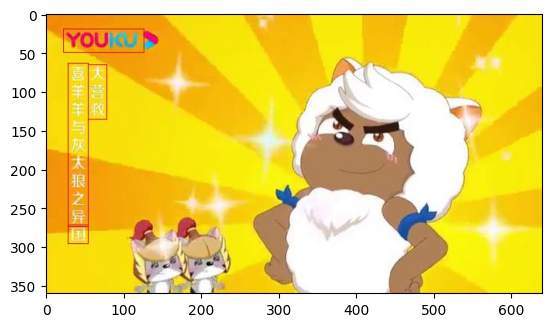

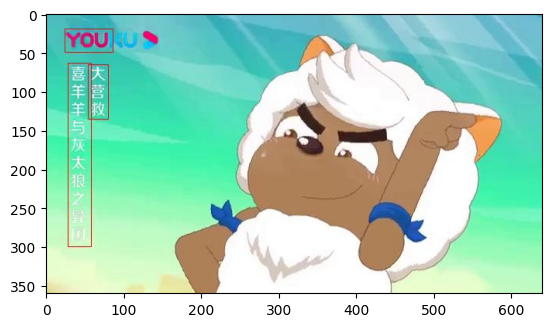

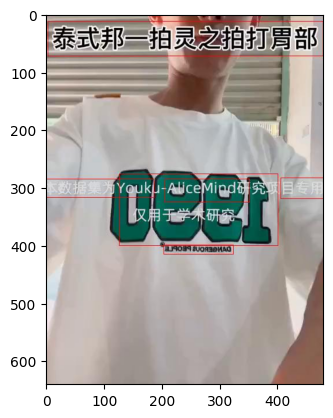

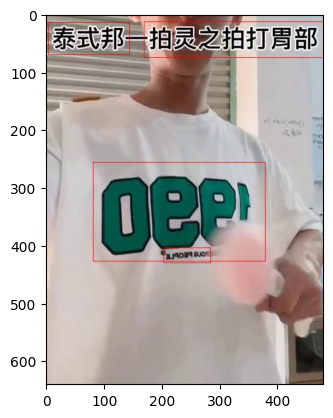

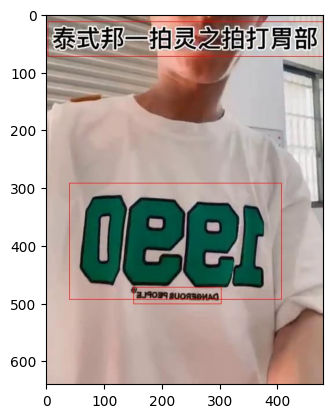

In [8]:
for s in ds:
    vid_path = s['videos'][0]
    for i in range(3):
        show_imgs(f'{vid_path}-{i}.jpg')

As we can see, the text area in the video2 is much larger than the text area in the video1, so video2 is removed from the space perspective.

## From Time Perspective

From the time perspective, we take `video_motion_score_filter` as an example. This OP would analyze the dense optical flow of the videos and compute a motion score to indicate how dynamic the videos are. In general, researchers expected more dynamic videos, so those relatively static videos will be removed.

We can write a new recipe for this OP as well.

In [12]:
recipe = '''
dataset_path: ds.jsonl
export_path: outputs/video_time_output/res.jsonl

keep_stats_in_res_ds: true  # keep the computed stats in the result dataset

process:
  - video_motion_score_filter:
      min_score: 2.0
'''

with open('video_time.yaml', 'w') as fout:
    fout.write(recipe)

Then we can run the process program of Data-Juicer to process the dataset.

In [13]:
!dj-process --config video_time.yaml

2024-08-12 17:50:22 | INFO     | data_juicer.config.config:618 - Back up the input config file [/root/projects/kdd_tutorial_notebooks/video_time.yaml] into the work_dir [/root/projects/kdd_tutorial_notebooks/outputs/video_time_output]
2024-08-12 17:50:22 | INFO     | data_juicer.config.config:640 - Configuration table: 
╒═════════════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ key                     │ values                                                                      │
╞═════════════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ config                  │ [Path_fr(video_time.yaml, cwd=/root/projects/kdd_tutorial_notebooks)]       │
├─────────────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ hpo_config              │ None                                                                        │
├─────────────────────────┼───────────────

We can check the processed results and check the stats.

In [16]:
with jl.open('outputs/video_time_output/res.jsonl') as reader:
    for s in reader:
        print(s)

{'text': '<__dj__video>', 'videos': ['/root/projects/kdd_tutorial_notebooks/vids/video2.mp4'], '__dj__stats__': {'video_motion_score': [3.5211100578]}}


Similar to the previous OP, we can add a snippet of code to visualize the dense optical flows of videos. The motion score is computed by averaging the magnitude of optical flows, so we can check the optical flow changes to check how dynamic these two videos are intuitively.

In the code of this OP, add these two lines of code and the optical flows will be written into the images.

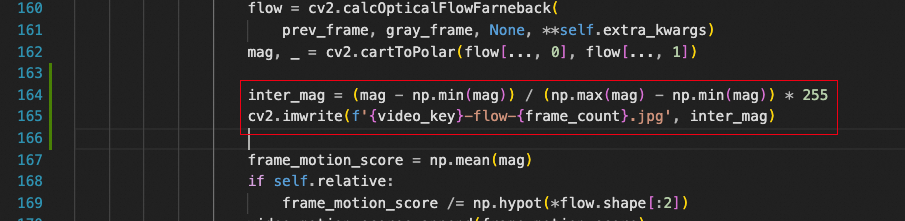

And then, we can write a function to visiualize the optical flows of these videos.

In [23]:
from IPython.display import clear_output, display
from PIL import Image
import os
import time

def show_optical_flows(video_path):
    frame_count = 0
    step = 12
    while True:
        clear_output(wait=True)
        fn = f'{video_path}-flow-{frame_count}.jpg'
        if not os.path.exists(fn):
            break

        img = Image.open(fn)
        display(img)
        time.sleep(0.02)

        frame_count += step

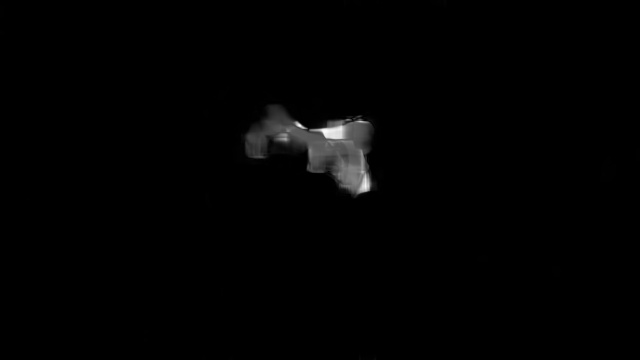

In [26]:
show_optical_flows('vids/video1.mp4')

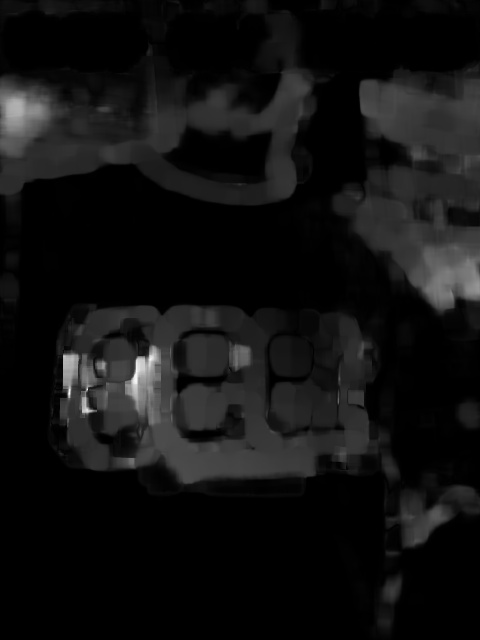

In [25]:
show_optical_flows('vids/video2.mp4')

As we can see, the dense optical flows are significant mostly on the edges of the white sheep in the video1. But in the video2, they get large magnitudes on the edges of clothes, texts on the clothes and the hands of the people in the video, which is more significant than video1. That's why the motion score of video2 is larger than the one of video1 and only the video2 is kept after processed by this OP.

# Conclusion

In this notebook, we learn how to process a video datasets from both spacetime perspectives through two example OPs and how researchers think about the stats generated by these two OPs in general.